# 混淆矩陣
<img src="image/confusionMatrix.png" width="400">  

* 精準度(precision): 所有預測為正，實際上為正的比率　$PRE = \frac{TP}{TP + FP}$  
* 召回率(recall): 所有實際上為正，被預測正確的比率　$REC = \frac{TP}{TP + FN}$
* F1-Score: 精準度與召回率的調和平均 $F1 = 2\frac{PRE \times REC}{PRE + REC}$

In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

#df = pd.read_csv('data/wdbc.data', header=None)
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, 
                     test_size=0.20,
                     stratify=y,
                     random_state=1)

## Scikit-Learn 混淆矩陣

In [2]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)


[[71  1]
 [ 2 40]]


## 混淆矩陣Matplot視覺化

<function matplotlib.pyplot.show(*args, **kw)>

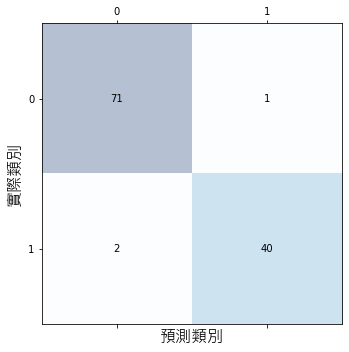

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('預測類別',fontproperties="Microsoft JhengHei",fontsize = 16)
plt.ylabel('實際類別',fontproperties="Microsoft JhengHei",fontsize = 16)

plt.tight_layout()
#plt.savefig('images/06_09.png', dpi=300)
plt.show

## Scikit-Learn Pre,Rec,F1 Score

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('精確率Pre: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('召回率Rec: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1 Score: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

精確率Pre: 0.976
召回率Rec: 0.952
F1 Score: 0.964
